### Imports

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
import lang2vec.lang2vec as l2v
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import chi2_contingency
from datetime import datetime

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',None)
NFOLDS = 10
SEED = 7

### Set arguments

At a later stage the parameters below can become argparse parameters

In [3]:
overwrite_chi2 = False
remove_correlated = False
encoding = "ordinal"
use_syn_dist=True
remove_weird_pairs = False
is_same = False
selection = "all"

### Load data

#### Load table with language features

In [4]:
lang_feats = pd.read_excel("../../xtreme_langs_wals.xlsx", index_col=0)

In [5]:
lang_feats.head()

ISO 693-2 wals_code iso_code glottocode                      Name  \
ISO 693-1                                                                     
af              afr       afr      afr   afri1274                 Afrikaans   
ar              ara       ams      ara   stan1318  Arabic (Modern Standard)   
bg              bul       bul      bul   bulg1262                 Bulgarian   
bn              ben       ben      ben   beng1280                   Bengali   
de              deu       ger      deu   stan1295                    German   

           latitude  longitude     genus         family  #feats macroarea  \
ISO 693-1                                                                   
af            -31.0       22.0  Germanic  Indo-European      16    Africa   
ar             25.0       42.0   Semitic   Afro-Asiatic      30   Eurasia   
bg             42.5       25.0    Slavic  Indo-European      71   Eurasia   
bn             24.0       90.0     Indic  Indo-European      36   Eurasia   
de             52.0       10.0  Germanic  Indo-European     138   Eurasia   

                                                                countrycodes  \
ISO 693-1                                                                      
af                                                                        ZA   
ar         LB QA KW SO KM YE PS JO ER SA IQ SY OM AE LY BH IL MA DZ EG SD TN   
bg                                                                        BG   
bn                                                                     BD IN   
de                                                                  AT DE CH   

          20A Fusion of Selected Inflectional Formatives  \
ISO 693-1                                                  
af                                                   NaN   
ar                                                   NaN   
bg                                                   NaN   
bn                                                   NaN   
de                           1 Exclusively concatenative   

          21A Exponence of Selected Inflectional Formatives  \
ISO 693-1                                                     
af                                                      NaN   
ar                                                      NaN   
bg                                                      NaN   
bn                                                      NaN   
de                                          2 Case + number   

          22A Inflectional Synthesis of the Verb  \
ISO 693-1                                          
af                                           NaN   
ar                                           NaN   
bg                                           NaN   
bn                                           NaN   
de                     2 2-3 categories per word   

          23A Locus of Marking in the Clause  \
ISO 693-1                                      
af                                       NaN   
ar                                       NaN   
bg                                       NaN   
bn                                       NaN   
de                       2 Dependent marking   

          24A Locus of Marking in Possessive Noun Phrases  \
ISO 693-1                                                   
af                                                    NaN   
ar                                                    NaN   
bg                                                    NaN   
bn                                                    NaN   
de                                    2 Dependent marking   

          25A Locus of Marking: Whole-language Typology  \
ISO 693-1                                                 
af                                                  NaN   
ar                                                  NaN   
bg                                                  NaN   
bn                                                  NaN   
de      

In [6]:
lang_feats.shape

(40, 185)

Display unique values of selected features

#### Load language pairs with scores

In [7]:
pair_scores = pd.read_csv("xnli_lang_pair_scores.csv")

In [8]:
pair_scores.head()

train_lang test_lang       acc
0         ar        ar  0.717959
1         ar        bg  0.745681
2         ar        de  0.755323
3         ar        el  0.741663
4         ar        en  0.793090

In [9]:
feat_cols = lang_feats.dropna(axis=1,how='all').columns[12:]

### Prepare dataset

In [10]:
final_arr = []


if is_same:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        
        switched_acc = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].acc.values[0]
        avg_acc = (switched_acc+pair_scores.at[i,"acc"])/2
        
        switched_f1 = pair_scores[(pair_scores.train_lang==test_lang)&(pair_scores.test_lang==train_lang)].f1.values[0]
        avg_f1 = (switched_acc+pair_scores.at[i,"f1"])/2
        
        train_feats = [train_lang, test_lang,avg_acc, avg_f1] + list((lang_feats.loc[train_lang,feat_cols]==lang_feats.loc[test_lang,feat_cols]).values)
        final_arr.append(train_feats)
        
    feat_cols = ["is_"+col.split()[0]+"_same" for col in feat_cols]
else:
    for i in pair_scores.index:
        train_lang = pair_scores.at[i,"train_lang"]
        test_lang = pair_scores.at[i,"test_lang"]
        train_feats =  list(pair_scores.iloc[i,:].values) + list(lang_feats.loc[train_lang,feat_cols].values) + list(lang_feats.loc[test_lang,feat_cols].values)
        final_arr.append(train_feats)
        
    feat_cols = [col.split()[0]+"_train" for col in feat_cols]+ [col.split()[0]+"_test" for col in feat_cols]
    
final_cols = list(pair_scores.columns)+feat_cols

final_df = pd.DataFrame(data=final_arr,columns=final_cols)

In [11]:
final_df.shape

(225, 323)

In [12]:
xnli_langs = final_df.train_lang.unique()

In our experiments it appears that the performance improved when we exclude pairs when the same language is used for training and testing. Therefore we remove them here.

In [13]:
final_df = final_df[final_df['train_lang']!=final_df['test_lang']]

### Kruskal correlation between target and every feature per lang

In [14]:
import scipy.stats as stats
def kruskal_per_lang(x):
    kruskal = {"test_lang":[],"feature":[],"h":[],"p":[],"result":[]}
    alpha = 0.05
    test_feats = [col for col in x.columns if "_train" in col]
    assert len(test_feats)>0,"Set is_same to False"
    test_lang = x.iat[0,1]
    for col in test_feats:
        col_df = x[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            h, p = stats.kruskal(*groups)
            if p<alpha:
                result = 'Dependent (reject H0)'
            else:
                result = 'Independent (fail to reject H0)'
            kruskal["test_lang"].append(test_lang)
            kruskal['feature'].append(col)
            kruskal['h'].append(h)
            kruskal['p'].append(p)
            kruskal['result'].append(result)
    
    kruskal = pd.DataFrame.from_dict(kruskal)
    return kruskal

kruskal_test = final_df.groupby(by="test_lang").apply(kruskal_per_lang).reset_index(drop=True)
min_p_ixs = kruskal_test.groupby(by='test_lang').p.idxmin()
most_corr_per_lang = kruskal_test.loc[min_p_ixs,:]
most_corr_per_lang

test_lang     feature         h         p  \
26          ar   46A_train  9.104420  0.027934   
171         bg   67A_train  8.076923  0.004483   
307         de   76A_train  6.027397  0.014085   
448         el   93A_train  5.914207  0.015019   
573         en   93A_train  6.648777  0.009922   
685         es   76A_train  6.027397  0.014085   
847         fr  113A_train  6.593272  0.010236   
933         hi   68A_train  7.720657  0.052152   
1102        ru  113A_train  7.568807  0.005939   
1247        sw  136A_train  5.727273  0.016703   
1370        th  127A_train  6.545455  0.010515   
1450        tr   76A_train  6.027397  0.014085   
1532        ur   29A_train  7.265789  0.026440   
1738        vi  114A_train  7.106061  0.028638   
1870        zh  120A_train  6.000000  0.014306   

                               result  
26              Dependent (reject H0)  
171             Dependent (reject H0)  
307             Dependent (reject H0)  
448             Dependent (reject H0)  
573             Dependent (reject H0)  
685             Dependent (reject H0)  
847             Dependent (reject H0)  
933   Independent (fail to reject H0)  
1102            Dependent (reject H0)  
1247            Dependent (reject H0)  
1370            Dependent (reject H0)  
1450            Dependent (reject H0)  
1532            Dependent (reject H0)  
1738            Dependent (reject H0)  
1870            Dependent (reject H0)

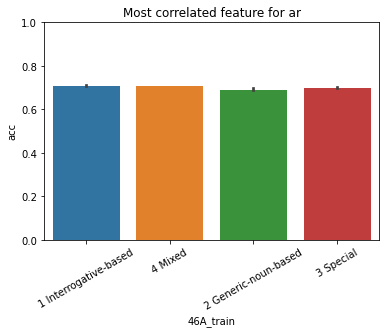

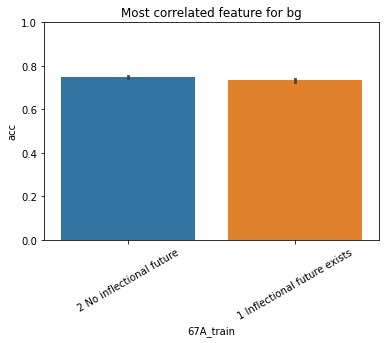

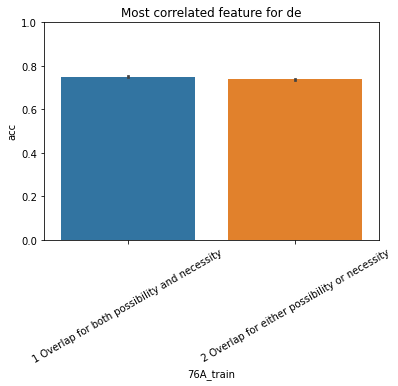

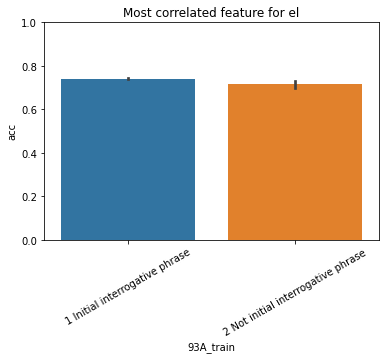

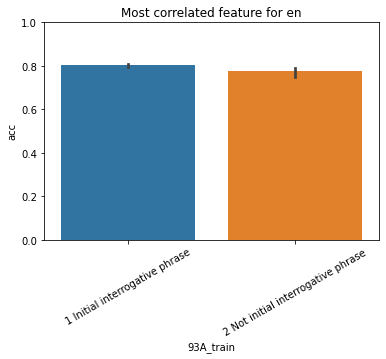

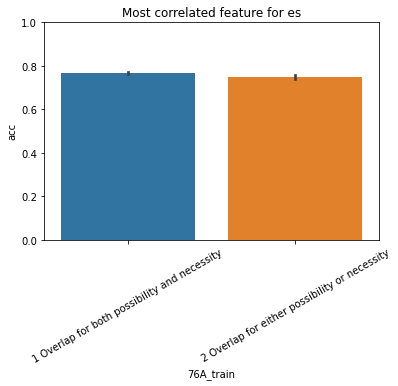

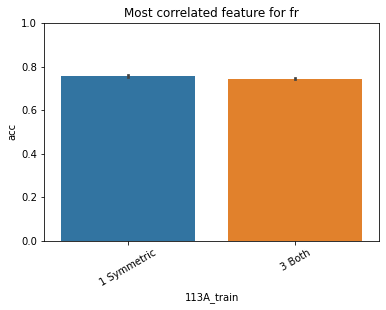

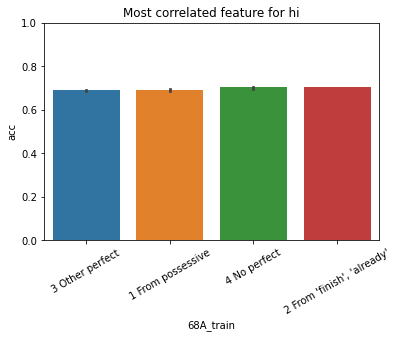

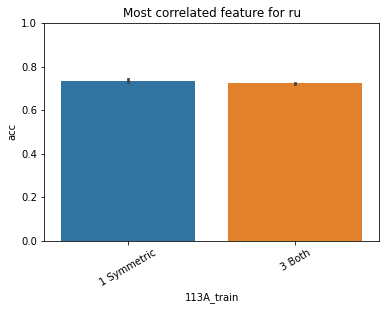

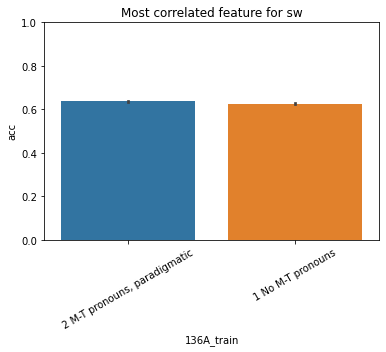

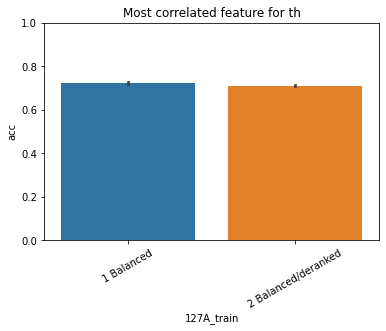

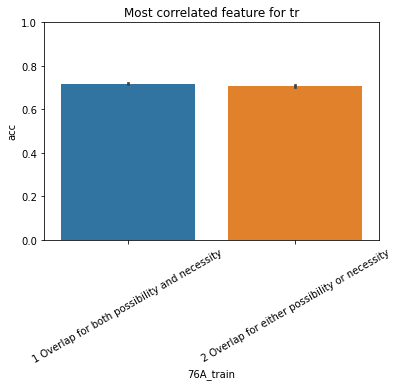

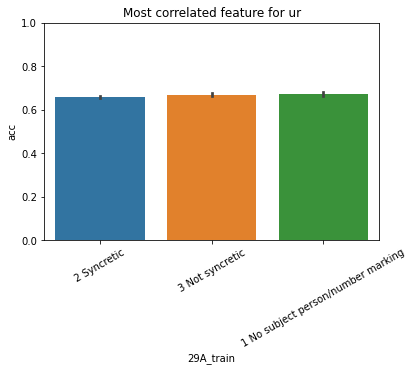

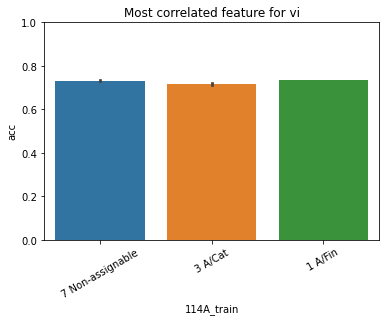

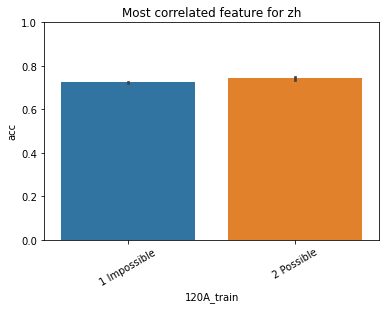

Feature 113A_train
Langs ['fr' 'ru']
Feature 114A_train
Langs ['vi']
Feature 120A_train
Langs ['zh']
Feature 127A_train
Langs ['th']
Feature 136A_train
Langs ['sw']
Feature 29A_train
Langs ['ur']
Feature 46A_train
Langs ['ar']
Feature 67A_train
Langs ['bg']
Feature 68A_train
Langs ['hi']
Feature 76A_train
Langs ['de' 'es' 'tr']
Feature 93A_train
Langs ['el' 'en']


In [15]:
import seaborn as sns

def plot_most_corr(x):
    test_lang = x.iat[0,0]
    most_corr_feat = x.iat[0,1]
#     if most_corr_feat=="93A_train":
    ax = sns.barplot(x=most_corr_feat, y="acc", data=final_df[final_df.test_lang==test_lang])
    plt.title("Most correlated feature for {}".format(test_lang))
    plt.xticks(rotation=30)
    plt.ylim([0,1])
    plt.show()
    
kpl = True
if kpl:    
    most_corr_per_lang.groupby(by="test_lang").apply(plot_most_corr)


#     langs = ['bg', 'et', 'fi', 'he', 'id', 'nl', 'ru']
#     lang_feats = lang_feats.reset_index()
#     lang_feats['93A Position of Interrogative Phrases in Content Questions']

    def output(x):
        print("Feature",x.iat[0,1])
        print("Langs",x.test_lang.unique())
    most_corr_per_lang.groupby(by="feature").apply(output)

    most_corr_per_lang['feature'].value_counts()



In [16]:
if kpl: 
    display(kruskal_per_lang(final_df).sort_values(by='p').head())

test_lang    feature          h         p                 result
65        bg  90A_train  14.930103  0.000573  Dependent (reject H0)
25        bg  45A_train  17.219656  0.000637  Dependent (reject H0)
28        bg  49A_train  15.535880  0.003710  Dependent (reject H0)
70        bg  95A_train  10.982525  0.004123  Dependent (reject H0)
58        bg  83A_train  10.838905  0.004430  Dependent (reject H0)

### Kruskal feature selection

In [17]:
if selection=="kruskal":
    alpha = 0.05
    dep_cols = []
    for col in feat_cols:
        col_df = final_df[[col,'acc']].dropna()
        if col_df[col].nunique()>1:
            groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
            if stats.kruskal(*groups).pvalue<alpha:
                dep_cols.append(col)

Delete features that have only missing values

### Add syntactical distance

We are using ISO 369-2 and lang2vec is using ISO 369-3, but they mostly overlap. For UD POS only Malay does not have a precomputed distance (its ISO 369-1 is "ms", ISO 369-2 is "may" and ISO 369-3 is "mly"). Therefore we delete it from the list to avoid errors.

In [18]:
if use_syn_dist:
    lang_codes_2 = list(lang_feats['ISO 693-2'].values)
    lang_codes_2.remove("may")
    lang_codes_1 = list(lang_feats.index)
    lang_codes_1.remove("ms")
    synt_dist = pd.DataFrame(data=l2v.syntactic_distance(lang_codes_2),index=lang_codes_1,columns=lang_codes_1)

    for i in final_df.index:
        train_lang = final_df.at[i,"train_lang"]
        test_lang = final_df.at[i,"test_lang"]
        try:
            final_df.at[i,"syn_dist"] =  synt_dist.at[train_lang, test_lang]
        except:
            print("Language not in URIEL")
    #       TODO: for now just add a place holder for languages that are not in the URIEL database, later compute the vectors yourself
            final_df.at[i,"syn_dist"] = -1

### Other preprocessing

#### Remove French test pairs, German-English pair and all Chinese and Japanese pairs

In [19]:
if remove_weird_pairs:
    removed_pairs = (final_df.train_lang.isin(['ja','zh'])) | (final_df.test_lang.isin(['ja','zh']))
    final_df = final_df[~removed_pairs]

In [20]:
final_df = final_df.dropna(axis=1,how='all')

In [21]:
lang_feats.columns

Index(['ISO 693-2', 'wals_code', 'iso_code', 'glottocode', 'Name', 'latitude',
       'longitude', 'genus', 'family', '#feats',
       ...
       '137B M in Second Person Singular', '136B M in First Person Singular',
       '109B Other Roles of Applied Objects',
       '10B Nasal Vowels in West Africa',
       '25B Zero Marking of A and P Arguments',
       '21B Exponence of Tense-Aspect-Mood Inflection',
       '108B Productivity of the Antipassive Construction',
       '130B Cultural Categories of Languages with Identity of 'Finger' and 'Hand'',
       '58B Number of Possessive Nouns',
       '79B Suppletion in Imperatives and Hortatives'],
      dtype='object', length=185)

### Fill missing values

In [22]:
cat_cols = list(final_df.select_dtypes(include=['object']).columns)

In [23]:
final_df[cat_cols] = final_df[cat_cols].fillna("0 Missing")

In [24]:
final_df.isna().any().any()

False

### Encode categorical variables (i.e. all of them)

In [25]:
if encoding=="ordinal":
    mappings = []
    for col in cat_cols:
        unique_vals = final_df[col].unique()
    #     every value starts with an index number, additionally we mark missing as 0
        sorted_vals = sorted(unique_vals, key=lambda element: [element[0]])
        mappings.append(sorted_vals)

    oe = OrdinalEncoder(categories=mappings)
    oe.fit(final_df[cat_cols])
    final_df[cat_cols] = oe.transform(final_df[cat_cols])
elif encoding=="onehot":
    from sklearn.preprocessing import OneHotEncoder

    one_hot = pd.get_dummies(final_df[cat_cols])
    final_df = final_df.drop(cat_cols,axis=1)
    final_df = pd.concat([final_df,one_hot],axis=1)
    
    cols_with_brackets = [col for col in final_df.columns if '[' in col ]
    brackets_dict = {}
    for col in cols_with_brackets:
        brackets_dict[col] = re.sub("\[|\]", "", col) # remove square brackets
    final_df = final_df.rename(columns=brackets_dict)
else:
    raise Exception("Incorrect encoding name. Choose between \"ordinal\" and \"onehot\"")

### Functions for training and evaluation

In [26]:
def fold_metrics(model, x_train, y_train, x_val, y_val, metrics_dict,debug=False): 
    y_preds = model.predict(x_train)
    fold_train = np.sqrt(mean_squared_error(y_train,y_preds))
    
    y_preds_val = model.predict(x_val)
    fold_val = np.sqrt(mean_squared_error(y_val,y_preds_val))


    
    metrics_dict['train']['rmse'].append(fold_train)
    metrics_dict['test']['rmse'].append(fold_val)
    
    if debug:
        metrics = pd.DataFrame.from_dict({'train':[fold_train],
                                         'test':[fold_val]})
        metrics.index = ['rmse']
        display(metrics)

In [27]:
def mean_fold_metrics(metrics_dict):
    
    train_rmse = np.mean(metrics_dict['train']['rmse'])
    test_rmse = np.mean(metrics_dict['test']['rmse'])
                        
    metrics = pd.DataFrame.from_dict({'train':[train_rmse],'test':[test_rmse]})
    metrics.index = ['rmse']
    
    print()
    print("Mean fold metrics")
    display(metrics)
    return metrics

In [28]:
def train_model(X, y, folds, params=None, X_test=None, model_type='lgb',n_jobs=-1, n_estimators=None, plot_feature_importance=True,save_importance = True,verbose=500,early_stopping_rounds=None):
#     add n_estimators and early_stopping as arguments in lgbm
    print("Model type",model_type)
    metrics_dict = {'train':{'rmse':[]},
                   'test':{'rmse':[]}}
    result_dict = {}
    n_splits = folds.n_splits
    columns = X.columns
    # averaged predictions on test data
    if X_test is not None:
        prediction = np.zeros((len(X_test), 1))
    
    feature_importance = pd.DataFrame()
    
    if params is None:
        params = {}
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
#         print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type=='lgb':
            model = lgb.LGBMClassifier(**params, importance_type='gain')
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=verbose)
    #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        elif model_type=='xgb':
            model = xgb.XGBRegressor(**params,random_state=SEED)
            model.fit(X_train, y_train)
            #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='linear':
            model = LinearRegression()
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='lasso':
            model = Lasso(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='dt':
            model = DecisionTreeRegressor(max_depth=10,max_leaf_nodes=10,random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='rf':
            model = RandomForestRegressor(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        else:
            raise Exception("Invalid model type")
                    
        fold_metrics(model,X_train,y_train,X_valid,y_valid,metrics_dict)
        
        if X_test is not None:
            prediction += y_pred.reshape(-1, 1)
        if plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            if model_type=='linear':
                fold_importance["importance"] = model.coef_
            else:
                fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    
    if X_test is not None:
        prediction /= n_splits
    
    result_dict['metrics'] = mean_fold_metrics(metrics_dict)
    if X_test is not None:
        result_dict['prediction'] = prediction.flatten()
        
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_splits
        if model_type=="linear":
            best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index(level=['feature'])
        else:
            best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].reset_index(level=['feature'])


        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features);
        plt.title('{} Features (avg over folds) overwrite_chi2 = {} remove_correlated = {} encoding = {} use_syn_dist = {} remove_weird_pairs = {}'.format(model_type.upper(),
                                                    overwrite_chi2,
                                                    remove_correlated,
                                                    encoding,
                                                    use_syn_dist,
                                                    remove_weird_pairs));
        
        if save_importance:
            now = datetime.now() 
            now = now.strftime("%d_%m_%Y_%H_%M")
            plt.savefig("Feature importance {}.jpg".format(now),dpi=500, bbox_inches='tight')
        
        result_dict['feature_importance'] = feature_importance
        result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict, model

### Train models

In [29]:
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

#### On all features

In [30]:
# X = final_df.drop(['acc','f1','syn_dist'],axis=1)
if selection=="all":
    if use_syn_dist:
        X = final_df.drop(['acc','syn_dist'],axis=1)
#         [["26A_train_1 Little affixation","26A_train_2 Strongly suffixing","26A_train_5 Weakly prefixing", "28A_train_1 No case marking","28A_train_2 Core cases only","28A_train_3 Core and non-core","28A_train_4 No syncretism"]]
    else:
        X = final_df.drop(['acc'],axis=1)
    y = final_df['acc']
elif selection=="kruskal":
    X = final_df[dep_cols]
    y = final_df['acc']
elif selection=="stepwise":
    X = final_df[best_stepwise]
    y = final_df['acc']

In [31]:
final_df.head()

train_lang  test_lang       acc  20A_train  21A_train  22A_train  \
1         0.0        1.0  0.745681        0.0        0.0        0.0   
2         0.0        2.0  0.755323        0.0        0.0        0.0   
3         0.0        3.0  0.741663        0.0        0.0        0.0   
4         0.0        4.0  0.793090        0.0        0.0        0.0   
5         0.0        5.0  0.764162        0.0        0.0        0.0   

   23A_train  24A_train  25A_train  26A_train  27A_train  28A_train  \
1        0.0        0.0        0.0        1.0        0.0        0.0   
2        0.0        0.0        0.0        1.0        0.0        0.0   
3        0.0        0.0        0.0        1.0        0.0        0.0   
4        0.0        0.0        0.0        1.0        0.0        0.0   
5        0.0        0.0        0.0        1.0        0.0        0.0   

   29A_train  30A_train  31A_train  32A_train  33A_train  34A_train  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   35A_train  36A_train  37A_train  38A_train  39A_train  40A_train  \
1        0.0        0.0        3.0        0.0        0.0        0.0   
2        0.0        0.0        3.0        0.0        0.0        0.0   
3        0.0        0.0        3.0        0.0        0.0        0.0   
4        0.0        0.0        3.0        0.0        0.0        0.0   
5        0.0        0.0        3.0        0.0        0.0        0.0   

   41A_train  42A_train  43A_train  44A_train  45A_train  46A_train  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   47A_train  48A_train  49A_train  50A_train  51A_train  52A_train  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   53A_train  54A_train  55A_train  56A_train  57A_train  58A_train  \
1        0.0        0.0        0.0        0.0        1.0        0.0   
2        0.0        0.0        0.0        0.0        1.0        0.0   
3        0.0        0.0        0.0        0.0        1.0        0.0   
4        0.0        0.0        0.0        0.0        1.0        0.0   
5        0.0        0.0        0.0        0.0        1.0        0.0   

   59A_train  60A_train  61A_train  62A_train  63A_train  64A_train  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   65A_train  66A_train  67A_train  68A_train  69A_train  70A_train  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
5        0.0        0.0        0.0        0.0        0.0        0.0   

   71A_train  72A_train  73A_train  74A_train  75A_train  76A_train  \
1        0.0        0.0        0.0        0.0        0.0        0.0   
2        0.0      

Try different models and compare results

In [32]:
final_df.shape

(210, 316)

In [33]:
# ['linear','lasso','dt','rf','xgb']
for est in ['linear','lasso','dt','rf','xgb']:
    results, model = train_model(X,y,folds,params=None,model_type=est,plot_feature_importance=False)

Model type linear

Mean fold metrics


train      test
rmse  0.00693  0.007936

Model type lasso

Mean fold metrics


train      test
rmse  0.041238  0.041025

Model type dt

Mean fold metrics


train      test
rmse  0.01328  0.017674

Model type rf

Mean fold metrics


train      test
rmse  0.004447  0.012933

Model type xgb

Mean fold metrics


train      test
rmse  0.001441  0.010678

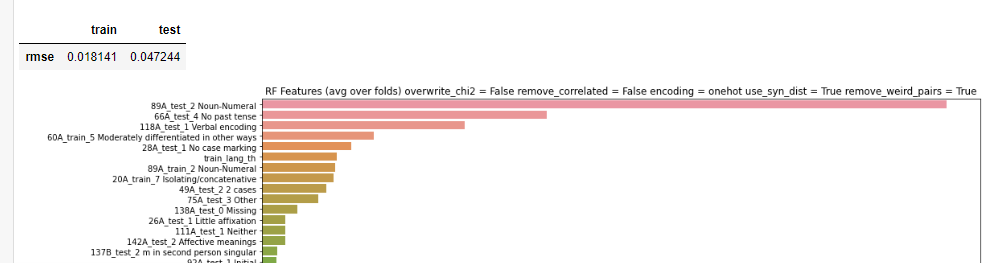

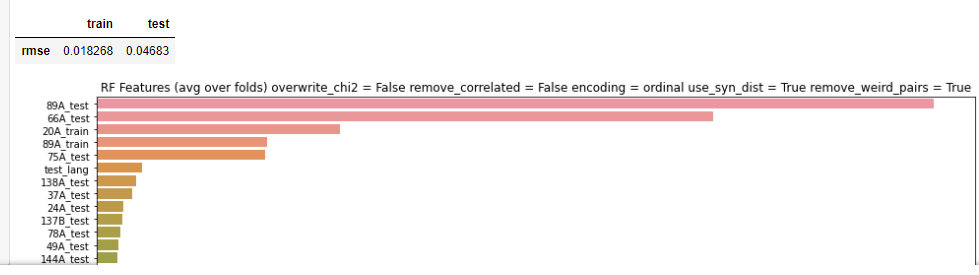

In [34]:
final_df.shape

(210, 316)

XGBoost obtains slightly better results than RF, but the former overfits dramatically.

### Analysing feature importance

Model type linear

Mean fold metrics


train      test
rmse  0.00693  0.007936

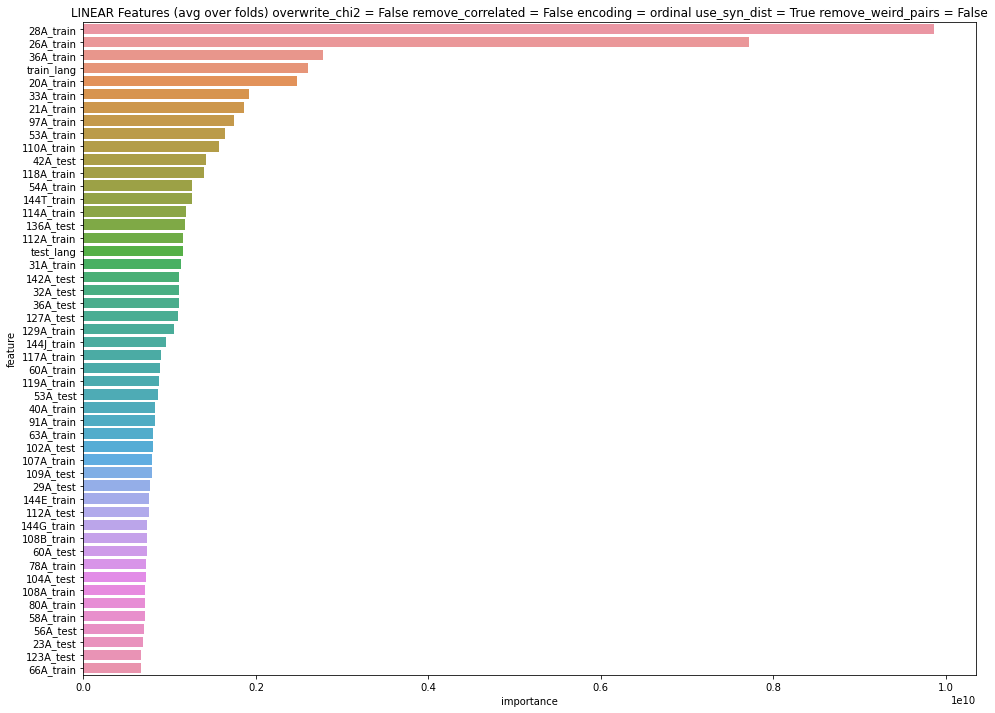

In [35]:
_, model = train_model(X,y,folds,params=None,model_type='linear',plot_feature_importance=True)

In [36]:
final_df.columns[11]

'28A_train'

#### With weird pairs

For one-hot encoding test rmse is 0.018815	and train is 0.04925. The most important feature is "34A Occurrence of Nominal Plurality" which distinguishes Japanese and Chinese from other languages.

For ordinal encoding, "55A_test" and "90B_train" are signficantly more important than other languages. Their full names are '55A Numeral Classifiers' and 90B Prenominal relative clauses.

#### Without weird pairs

Below we can see a visualization of a decision tree.

In [37]:
_, dt_model = train_model(X,y,folds,params=None,model_type='dt',plot_feature_importance=False)

Model type dt

Mean fold metrics


train      test
rmse  0.01328  0.017674

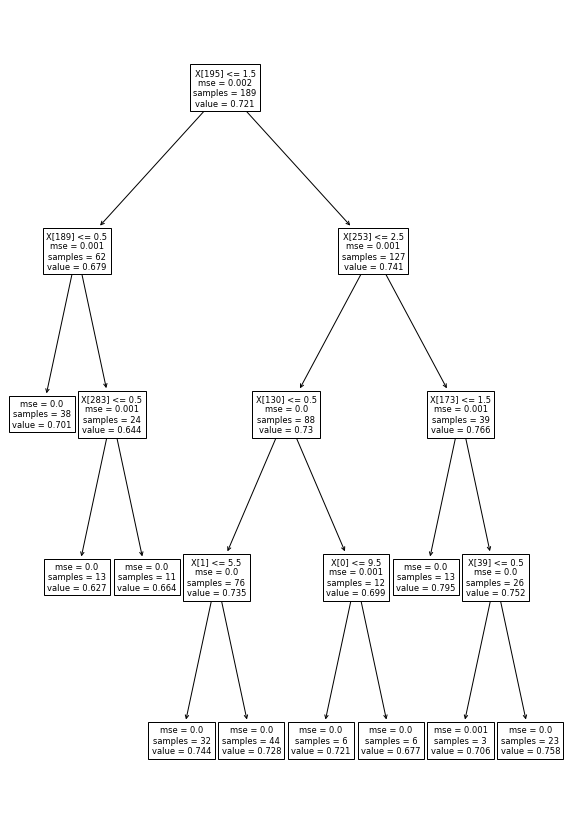

In [38]:
plt.figure(figsize=(10,15))
tree.plot_tree(dt_model);

In [39]:
X.columns[[195, 123, 259]]

Index(['57A_test', '90B_train', '121A_test'], dtype='object')

The two most important features are the same as for Random Forest. 

We can see that the languages with obligatory numeral classifiers are all from South-West Asia. On the other hand languages with missing feature 90B are usually European, while those that are not missing it are Asian.

#### By feature group

In [40]:
groups = {"morphology":list(range(20,30)),
"nom_cat":list(range(30, 58)),
"nom_synt":list(range(58, 65)),
"verb_cat":list(range(65, 81)),
"order":list(range(81, 98))+[143, 144],
"simp_claus":list(range(98, 122)),
"comp_sent":list(range(122, 129)),
"lexicon":list(range(129, 139)),
"other":list(range(141,143)),}


In [41]:
if encoding=="ordinal":
    final_feat_cols = final_df.columns[4:-1]
elif encoding=="onehot":
    final_feat_cols = final_df.columns[56:-1]
else:
    raise Exception("Select proper encoding.")

In [42]:

areas = []
metrics = []
for area in groups:
    group_range = groups[area]
    group_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in group_range]
    print("Group",area)
#     print("Cols",group_cols)
    X = final_df[group_cols]
    y = final_df['acc']
    results, model = train_model(X,y,folds,params=None,model_type='linear', plot_feature_importance=False)
    areas.append(area)
    metrics.append(results['metrics'])

Group morphology
Model type linear

Mean fold metrics


train     test
rmse  0.020132  0.02196

Group nom_cat
Model type linear

Mean fold metrics


train      test
rmse  0.006816  0.007939

Group nom_synt
Model type linear

Mean fold metrics


train      test
rmse  0.026862  0.028938

Group verb_cat
Model type linear

Mean fold metrics


train     test
rmse  0.006723  0.00772

Group order
Model type linear

Mean fold metrics


train     test
rmse  0.01246  0.01381

Group simp_claus
Model type linear

Mean fold metrics


train      test
rmse  0.006781  0.007802

Group comp_sent
Model type linear

Mean fold metrics


train      test
rmse  0.023358  0.025152

Group lexicon
Model type linear

Mean fold metrics


train      test
rmse  0.023222  0.024925

Group other
Model type linear

Mean fold metrics


train      test
rmse  0.040434  0.040307

In [43]:
group_results = pd.concat(metrics)
group_results["group"] = areas

In [44]:
group_results.sort_values(by="test")

train      test       group
rmse  0.006723  0.007720    verb_cat
rmse  0.006781  0.007802  simp_claus
rmse  0.006816  0.007939     nom_cat
rmse  0.012460  0.013810       order
rmse  0.020132  0.021960  morphology
rmse  0.023222  0.024925     lexicon
rmse  0.023358  0.025152   comp_sent
rmse  0.026862  0.028938    nom_synt
rmse  0.040434  0.040307       other

### Comparing to syntactical distance

#### Predict just with word order and syn_dist

Model type linear

Mean fold metrics


train      test
rmse  0.012148  0.013241

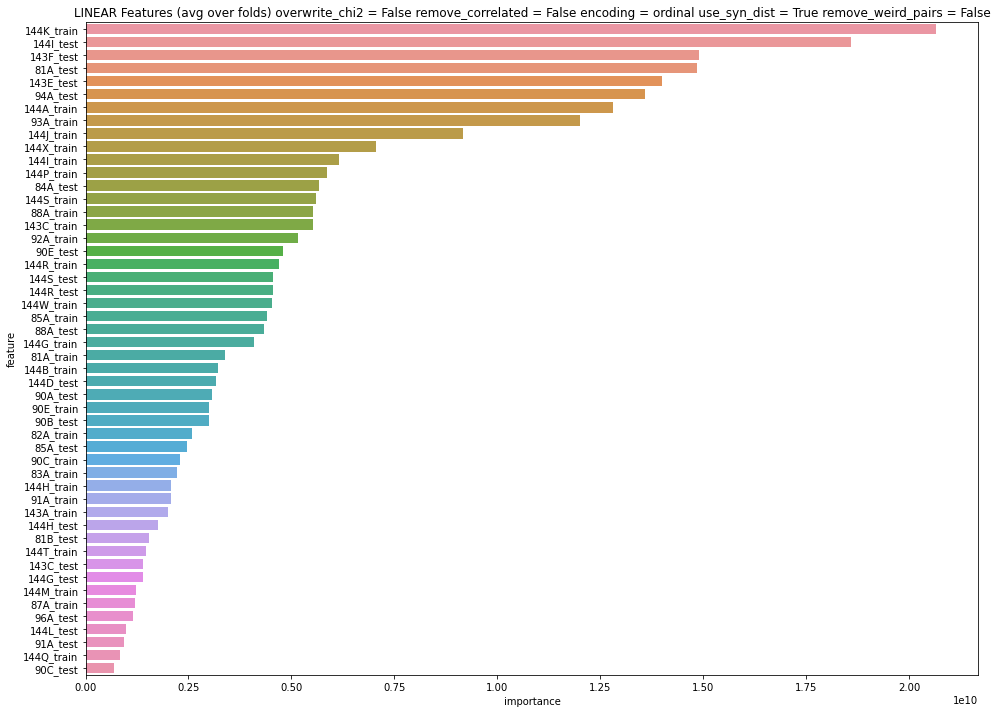

In [45]:
order_cols = [col for col in final_feat_cols if int(re.match("\d*", col).group()) in groups["order"]]
X = final_df[order_cols+["syn_dist"]]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear')

#### Predict with all features and syntactical distance

Model type linear

Mean fold metrics


train      test
rmse  0.006887  0.007858

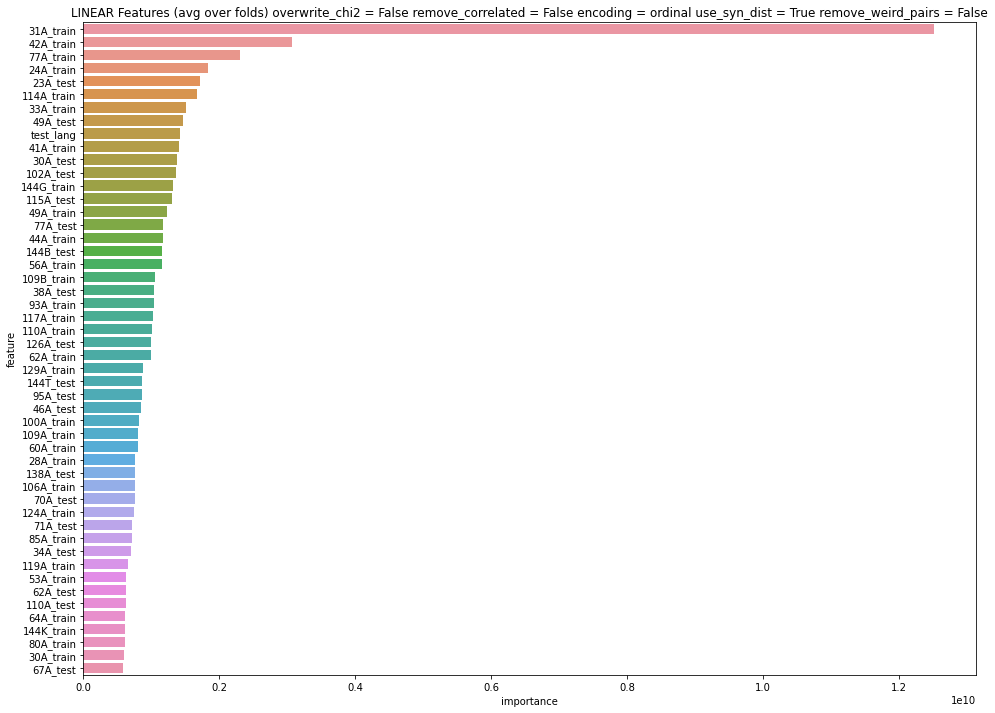

In [46]:
X = final_df.drop(['acc'],axis=1)
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear')

#### Predict with only syntactical distance

In [47]:
def select_best_degree(train, test, predictor,target):
    def make_features(train_set, test_set, degrees):
        train_dict = {}
        test_dict = {}
        for d in degrees:
            traintestdict={}
            train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
            test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        return train_dict, test_dict
    
    xtrain = train[predictor].values
    ytrain = train[target].values
    xtest = test[predictor].values
    ytest = test[target].values
    
    degrees=range(30)
    
    train_dict, test_dict = make_features(xtrain, xtest, degrees)

    error_train=np.empty(len(degrees))
    error_test=np.empty(len(degrees))
    
#     for all degrees train and evaluate the polynomial model
    for d in degrees:
#         intercept/bias is already provided by PolynomialFeatures
        model = LinearRegression(fit_intercept=False)
        model.fit(train_dict[d],ytrain.reshape(-1,1))
        predtrain = model.predict(train_dict[d])
        predtest = model.predict(test_dict[d])
        error_train[d] = np.sqrt(mean_squared_error(ytrain,predtrain))
        error_test[d] = np.sqrt(mean_squared_error(ytest,predtest))
    
#     get the best degree
    best_degree = np.argmin(error_test)
    
#     plot errors on train and test set
    plot_errors=False
    if plot_errors:
        plt.figure(figsize=(8,6))
        plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
        plt.plot(degrees, error_test, marker='o', label='test')
        plt.axvline(best_degree, 0,0.5, color='r', label="min test error at d=%d"%best_degree, alpha=0.3)
        plt.ylabel('RMSE')
        plt.xlabel('degree')
        plt.legend(loc='upper right')
        plt.title("Errors of polynomial models with different degrees for {}".format(target))
        plt.xticks(range(0,20,2))
    #     plt.savefig(f"{IMAGES_DIR}best_degree_{target}.jpg",dpi=500, bbox_inches = 'tight',pad_inches = 0)
        plt.yscale("log")
        print("Best degree",best_degree)
    return best_degree

In [48]:
best_degrees = []
for i in range(100):
    train, test = train_test_split(final_df[['syn_dist','acc']])
    best_degrees.append(select_best_degree(train, test, 'syn_dist','acc'))

In [49]:
best_degree_counts = pd.Series(best_degrees).value_counts()
best_degree_counts

3     23
2      9
21     9
10     8
8      7
29     5
4      5
17     5
1      5
19     3
28     3
20     3
9      3
27     3
18     2
6      2
16     1
11     1
22     1
23     1
24     1
dtype: int64

In [50]:
final_df = final_df[final_df.syn_dist!=-1]

In [51]:
X = final_df[['syn_dist']]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear',plot_feature_importance=False)

Model type linear

Mean fold metrics


train      test
rmse  0.040701  0.040786

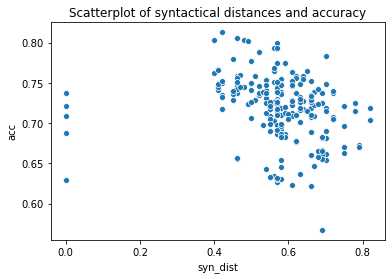

In [52]:
sns.scatterplot(x='syn_dist',y='acc',data=final_df)
plt.title("Scatterplot of syntactical distances and accuracy")
plt.show()

In [53]:
final_df.sort_values(by='syn_dist')

train_lang  test_lang       acc  20A_train  21A_train  22A_train  \
219        14.0        9.0  0.629972        3.0        1.0        1.0   
135         9.0        0.0  0.687425        1.0        3.0        3.0   
210        14.0        0.0  0.708317        3.0        1.0        1.0   
149         9.0       14.0  0.721173        1.0        3.0        3.0   
14          0.0       14.0  0.737244        0.0        0.0        0.0   
9           0.0        9.0  0.629168        0.0        0.0        0.0   
79          5.0        4.0  0.803536        1.0        1.0        3.0   
65          4.0        5.0  0.761752        1.0        3.0        2.0   
20          1.0        5.0  0.767376        0.0        0.0        0.0   
50          3.0        5.0  0.765769        1.0        2.0        3.0   
95          6.0        5.0  0.765769        1.0        3.0        3.0   
76          5.0        1.0  0.741663        1.0        1.0        3.0   
78          5.0        3.0  0.745279        1.0        1.0        3.0   
81          5.0        6.0  0.748092        1.0        1.0        3.0   
34          2.0        4.0  0.812776        1.0        2.0        2.0   
122         8.0        2.0  0.752913        1.0        2.0        3.0   
163        10.0       13.0  0.732824        3.0        3.0        2.0   
38          2.0        8.0  0.735235        1.0        2.0        2.0   
62          4.0        2.0  0.749699        1.0        3.0        2.0   
205        13.0       10.0  0.717557        2.0        3.0        1.0   
53          3.0        8.0  0.728405        1.0        2.0        3.0   
83          5.0        8.0  0.736440        1.0        1.0        3.0   
125         8.0        5.0  0.779831        1.0        2.0        3.0   
123         8.0        3.0  0.740458        1.0        2.0        3.0   
66          4.0        6.0  0.742467        1.0        3.0        2.0   
94          6.0        4.0  0.805544        1.0        3.0        3.0   
187        12.0        7.0  0.657292        0.0        0.0        0.0   
117         7.0       12.0  0.655685        1.0        1.0        2.0   
121         8.0        1.0  0.751306        1.0        2.0        3.0   
92          6.0        2.0  0.756529        1.0        3.0        3.0   
33          2.0        3.0  0.747288        1.0        2.0        2.0   
23          1.0        8.0  0.737646        0.0        0.0        0.0   
47          3.0        2.0  0.746886        1.0        2.0        3.0   
36          2.0        6.0  0.758939        1.0        2.0        2.0   
93          6.0        3.0  0.745279        1.0        3.0        3.0   
51          3.0        6.0  0.760145        1.0        2.0        3.0   
19          1.0        4.0  0.803536        0.0        0.0        0.0   
61          4.0        1.0  0.744877        1.0        3.0        2.0   
68          4.0        8.0  0.724387        1.0        3.0        2.0   
124         8.0        4.0  0.802330        1.0        2.0        3.0   
91          6.0        1.0  0.740860        1.0        3.0        3.0   
113         7.0        8.0  0.725994        1.0        1.0        2.0   
77          5.0        2.0  0.749297        1.0        1.0        3.0   
21          1.0        6.0  0.749297        0.0        0.0        0.0   
35          2.0        5.0  0.777421        1.0        2.0        2.0   
127         8.0        7.0  0.706710        1.0        2.0        3.0   
98          6.0        8.0  0.728405        1.0        3.0        3.0   
126         8.0        6.0  0.758538        1.0        2.0        3.0   
46          3.0        1.0  0.746083        1.0        2.0        3.0   
49          3.0        4.0  0.788670        1.0        2.0        3.0   
18          1.0        3.0  0.734833        0.0        0.0        0.0   
63          4.0        3.0  0.736842        1.0        3.0        2.0   
107         7.0        2.0  0.738851        1.0        1.0        2.0   
37          2.0        7.0  0.698272        1.0        2.0     

Pearson correlation between accuracy and syntactical distance

In [54]:
from scipy import stats

stats.pearsonr(final_df['acc'], final_df['syn_dist'])

(-0.1579610305166918, 0.022032644275296585)

### Predicting only with "A" features

Model type linear

Mean fold metrics


train      test
rmse  0.006992  0.007818

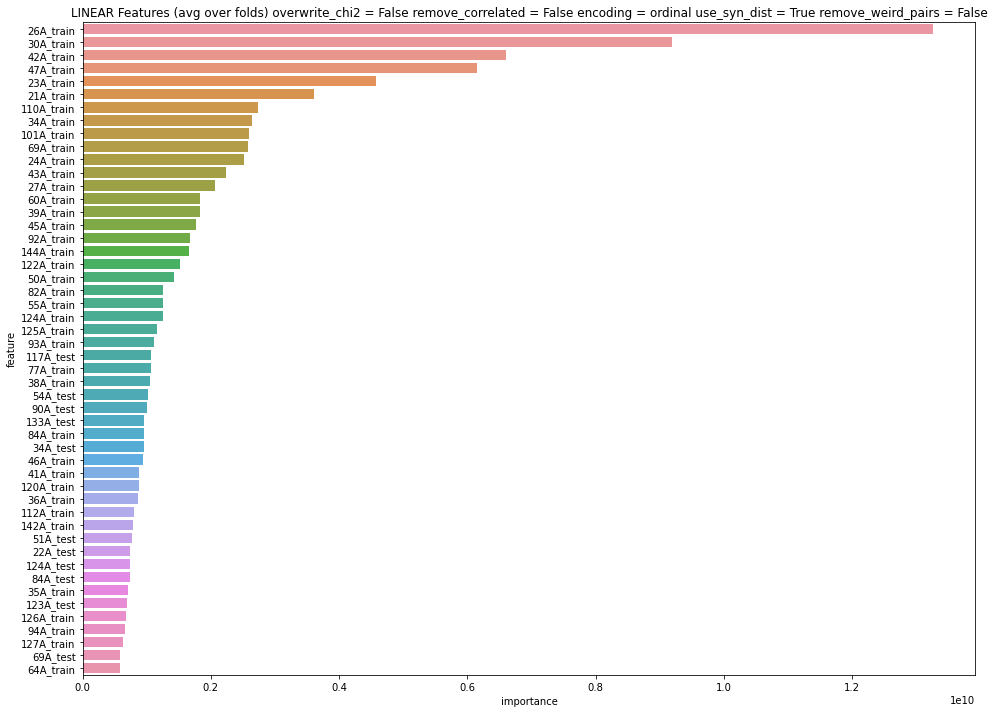

In [55]:
a_feats = [col for col in final_feat_cols if col.split("_")[0][-1]=="A"]

X = final_df[a_feats]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear')

In [56]:
np.max(model.coef_)

405230404033.6974

In [57]:
np.min(model.coef_)

-275519774565.65686

In [58]:
final_df.columns[12]

'29A_train'

### Predicting only with WBO features 

Model type linear

Mean fold metrics


train      test
rmse  0.027043  0.027976

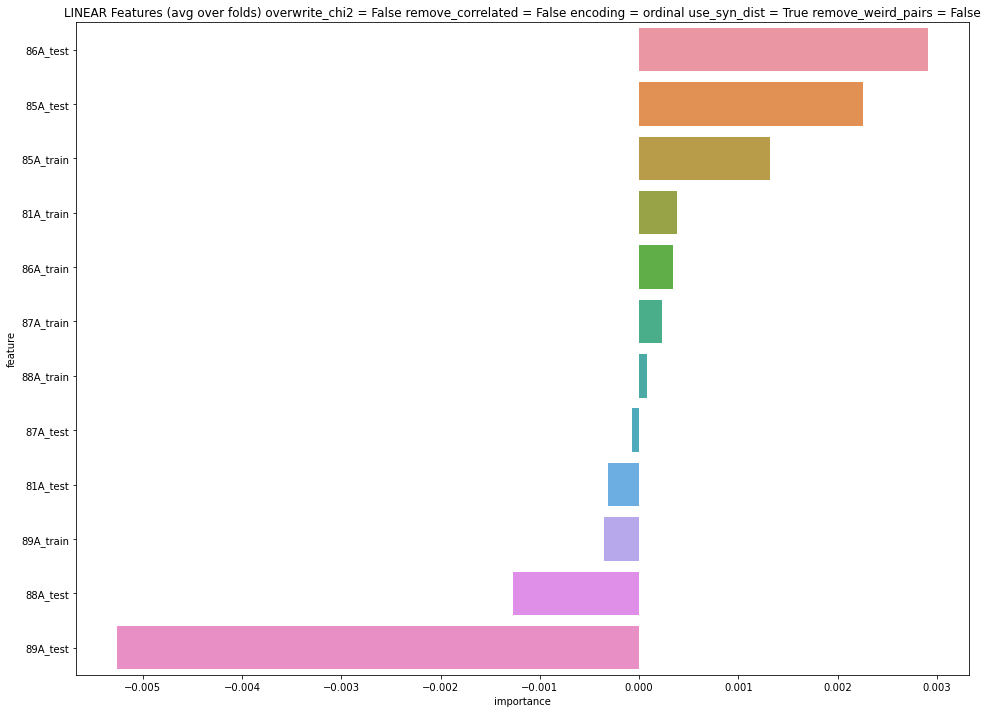

In [59]:
wbo = ['81A Order of Subject, Object and Verb',
'85A Order of Adposition and Noun Phrase',
'86A Order of Genitive and Noun',
'87A Order of Adjective and Noun',
'88A Order of Demonstrative and Noun',
'89A Order of Numeral and Noun']

wbo_cols = [col.split()[0]+"_train" for col in wbo]+ [col.split()[0]+"_test" for col in wbo]

X = final_df[wbo_cols]
y = final_df['acc']
results, model = train_model(X,y,folds,params=None,model_type='linear')

## Draft

In [ ]:
# params = {
#         'max_depth':3,
#         'min_child_weight':1,
#         'scale_pos_weight':weight_ratio,
#         'objective':'binary'
# }

In [ ]:
# split = int(0.9*final_df.shape[0])
# train = final_df.iloc[:split,:]
# test = final_df.iloc[split:,:]
# train.shape,test.shape

In [ ]:
final_df.shape

### XGB hyperparameter tuning - Random Search

In [ ]:
xgb_model = xgb.XGBRegressor()
distributions = {
    "n_estimators":[2,5,10,50,100],
    "max_depth":[3,4,5,8,10],
    "min_child_weight":[1,2,5]
#     lambda:
    
}

exhaustive = 1
for k in distributions:
    exhaustive *= len(distributions[k])
    
print(exhaustive)

random_search = RandomizedSearchCV(xgb_model, distributions, cv=10,n_iter=exhaustive,random_state=0,scoring='neg_mean_squared_error')
search = random_search.fit(X,y)

pd.DataFrame.from_dict(search.cv_results_)

params = search.best_params_

### Show column values

In [ ]:
cols = ['26A Prefixing vs. Suffixing in Inflectional Morphology','28A Case Syncretism']
for col in cols:
    print("Column",col)
    print("Values:")
    for val in sorted(lang_feats[col].dropna().unique(), key=lambda element: [element[0]]):
        print(val)
    print()

### Kruskal and anova

In [ ]:
import scipy.stats as stats
num_significant = {"anova":0,"kruskal":0}
alpha = 0.05
for col in feat_cols:
    col_df = final_df[[col,'acc']].dropna()
    if col_df[col].nunique()>1:
        groups = [list(col_df[col_df[col]==value].acc.values) for value in col_df[col].unique()]
        num_significant["kruskal"] += stats.kruskal(*groups).pvalue<alpha
#         print(stats.f_oneway(*groups).statistic,stats.f_oneway(*groups).pvalue)

### Stepwise selection

In [ ]:
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [ ]:
params= {"learning_rate":0.1,
"max_depth":4}

model = xgb.XGBRegressor(**params,random_state=SEED)

sfs_xgb = sfs(model,
           k_features=X.shape[1]-1,
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           n_jobs=7,
           cv=5)

# Perform SFFS
sfs_result = sfs_xgb.fit(X, y)

In [ ]:
scores = [sfs_result.subsets_[k]["avg_score"] for k in sfs_result.subsets_]

In [ ]:
np.argmax(scores)

In [ ]:
best_stepwise = list(sfs_result.subsets_[np.argmax(scores)+1]['feature_names'])

In [ ]:

import datetime 
  
now = datetime.datetime.now() 
now = now.strftime("%d_%m_%Y_%H_%M")
with open("forward_selection_{}.txt".format(now), "w") as f:
    n = f.write(str(sfs_result.subsets_))

### Important features

In [336]:

important_features = ["26A Prefixing vs. Suffixing in Inflectional Morphology", "28A Case Syncretism"]
for i, feat in enumerate(important_features):
    print()
    print(feat)
    for val in lang_feats[feat].unique():
        print(val)
        if not isinstance(val, str) and np.isnan(val):
            print(lang_feats.loc[xnli_langs,:][lang_feats[feat].isna()].Name.unique())
        else:
            print(lang_feats.loc[xnli_langs,:][lang_feats[feat]==val].Name.unique())
            
    for value in final_df[important_features[i].split()[0]+"_train"].unique():
        print("avg acc for this value", final_df[final_df[important_features[i].split()[0]+"_train"]==value].acc.mean())


26A Prefixing vs. Suffixing in Inflectional Morphology
nan
[]
2 Strongly suffixing
['Arabic (Modern Standard)' 'Bulgarian' 'German' 'Greek (Modern)'
 'English' 'Spanish' 'French' 'Hindi' 'Russian' 'Turkish' 'Urdu'
 'Mandarin']
4 Equal prefixing and suffixing
[]
3 Weakly suffixing
[]
5 Weakly prefixing
['Swahili']
1 Little affixation
['Thai' 'Vietnamese']
avg acc for this value 0.718145554726511
avg acc for this value 0.7172128795270618
avg acc for this value 0.7264535384262183

28A Case Syncretism
nan
['Arabic (Modern Standard)' 'Bulgarian' 'Urdu']
3 Core and non-core
['German' 'Greek (Modern)' 'Spanish' 'French' 'Hindi' 'Russian']
2 Core cases only
['English']
1 No case marking
['Swahili' 'Thai' 'Vietnamese' 'Mandarin']
4 No syncretism
['Turkish']
avg acc for this value 0.7058103273450802
avg acc for this value 0.7234641948382405
avg acc for this value 0.7117603168225909
avg acc for this value 0.7242294667967629
avg acc for this value 0.7209722780233027


C:\Users\bdolicki\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\bdolicki\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [250]:
final_df.train_lang.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

In [265]:
s = [i for i in lang_feats.index if i in final_df.train_lang.unique()]

In [275]:
lang_feats.loc[xnli_langs,:][lang_feats[feat]==val]

C:\Users\bdolicki\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


ISO 693-2 wals_code iso_code glottocode                      Name  \
ISO 693-1                                                                     
ar              ara       ams      ara   stan1318  Arabic (Modern Standard)   
bg              bul       bul      bul   bulg1262                 Bulgarian   
de              deu       ger      deu   stan1295                    German   
el              ell       grk      ell   mode1248            Greek (Modern)   
en              eng       eng      eng   stan1293                   English   
es              spa       spa      spa   stan1288                   Spanish   
fr              fra       fre      fra   stan1290                    French   
hi              hin       hin      hin   hind1269                     Hindi   
ru              rus       rus      rus   russ1263                   Russian   
tr              tur       tur      tur   nucl1301                   Turkish   
ur              urd       urd      urd   urdu1245                      Urdu   
zh              zho       mnd      zho   mand1415                  Mandarin   

           latitude  longitude     genus         family  #feats macroarea  \
ISO 693-1                                                                   
ar             25.0       42.0   Semitic   Afro-Asiatic      30   Eurasia   
bg             42.5       25.0    Slavic  Indo-European      71   Eurasia   
de             52.0       10.0  Germanic  Indo-European     138   Eurasia   
el             39.0       22.0     Greek  Indo-European     136   Eurasia   
en             52.0        0.0  Germanic  Indo-European     140   Eurasia   
es             40.0       -4.0   Romance  Indo-European     136   Eurasia   
fr             48.0        2.0   Romance  Indo-European     139   Eurasia   
hi             25.0       77.0     Indic  Indo-European     126   Eurasia   
ru             56.0       38.0    Slavic  Indo-European     137   Eurasia   
tr             39.0       35.0    Turkic         Altaic     135   Eurasia   
ur             25.0       67.0     Indic  Indo-European      42   Eurasia   
zh             34.0      110.0   Chinese   Sino-Tibetan     135   Eurasia   

                                                                countrycodes  \
ISO 693-1                                                                      
ar         LB QA KW SO KM YE PS JO ER SA IQ SY OM AE LY BH IL MA DZ EG SD TN   
bg                                                                        BG   
de                                                                  AT DE CH   
el                                                                        GR   
en                                                                     GB IE   
es                                                                        ES   
fr                                                                     FR CH   
hi                                                                        IN   
ru                                                                        RU   
tr                                                                        TR   
ur                                                                        PK   
zh                                                                        CN   

          20A Fusion of Selected Inflectional Formatives  \
ISO 693-1                                                  
ar                                                   NaN   
bg                                                   NaN   
de                           1 Exclusively concatenative   
el                           1 Exclusively concatenative   
en                           1 Exclusively concatenative   
es                           1 Exclusively concatenative   
fr                           1 Exclusively concatenative   
hi                           1 Exclusively concatenative   
ru                           1 Exclusively concatenative   
tr                           1 Exclusively 